# Lego Image Recognition - SVM
The goal of this notebook was to see how effective SVM's could be at image recognition, specifically with Lego's.

This script can be broken down into 3 main components

1. Data Ingestion and Initial Transformation
    - Ingest Data using parrallel processes to improve runtime
    - Remove bordering 50 pixels
2. Dimensionality Reduction
    - Reduce data from 9000+ features to 225 features to improve model runtime
3. Run Model
    - Perform hyperparameter selection and run the model on these "best" parameters along with printing scores and displaying confusion matrix
    
### NOTICE - For drastic reduction in runtime script was run on HPCC

#  Initial Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.io import imread,imshow
import pickle
import sys
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import concurrent.futures
import time
from skimage.transform import resize
from scipy.sparse import csr_matrix,vstack
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

# Data Ingestion and Initial Transformation

In [2]:
#Data Ingestion
images_df = pd.DataFrame()
images=[]
labels=[]
count=0
image_names=[]
for name in os.listdir(r"Dataset""):
    image_names.append(name)
images_df = pd.DataFrame()
labels_df = pd.DataFrame()
def image_processor(name):
    #Given the name of a file, read in that image, take its HOG, and save filename as label
    #Returns data (x), and label (y)
    #Replace string with path to dataset
    file = os.path.join(r"Dataset", name)
    
    #Read in image and get rid of 50 pixels border as most images the outside 50 points were not of significance
    data = imread(file,as_gray=True)
    data = data[50:-50,50:-50]
    data = data.flatten()
    #Command commented out, used for optimizing model runtime and overall memory usage
    #data = resize(data,(100,100))
    

    #Makes the filename the label, as dataset has the expected lego block as the filename
    label = file[:-8]
    label = label.rsplit("/",1)[1]
    return (data,label)
print("Starting Data Load and Transforms",time.asctime())

#Variables used for print statements for loading
count=0
thresh=10000


#Code below calls the image processor function and parallizes the image processing for us across multiple cores
#This significantly improces runtime, tqdm is used to create loading bar
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(image_processor,image_names),total=len(image_names)))
print("Finished Initial",time.asctime())


#Splits results into images and labels lists
for data,file in results:
    count+=1
    if count>thresh:
        print("Completed",count,"images",time.asctime())
        #break
        thresh = thresh +9999
    images.append(data)
    labels.append([file])    

import sys
print("Size of Images before Stack",sys.getsizeof(images))
print("Size of labels",sys.getsizeof(labels))


Starting Data Load and Transforms Mon Mar 11 13:51:19 2024


  0%|          | 0/40000 [00:00<?, ?it/s]

Finished Initial Mon Mar 11 13:52:35 2024
Completed 10001 images Mon Mar 11 13:52:35 2024
Completed 20000 images Mon Mar 11 13:52:35 2024
Completed 29999 images Mon Mar 11 13:52:35 2024
Completed 39998 images Mon Mar 11 13:52:35 2024
Size of Images before Stack 321104
Size of labels 321104


In [3]:
images_np = np.array(images)

# Dimensionality Reduction

In [7]:
#Code below used to run Principal Components Analysis on data in order to reduce runtime and memory complexity
#500 was chosen after plugging and playing and seeing resulting runtimes
pca_vals = []
total_pca = []
print("Beginning PCA Fit and Transform",time.asctime())
#Used to take sample of data for PCA experiment to reduce runtime and memory requirements by 1/4
ind = np.random.choice(images_np.shape[0],size=10000)
sample = images_np[ind]
for i in range(25,400,25):
    pca = PCA(n_components=i)
    pca.fit(sample)
    total_pca.append(pca.explained_variance_ratio_.sum())
    pca_vals.append(i)
    print(i,pca.explained_variance_ratio_.sum(),time.asctime())

print("Finished",time.asctime())


Beginning PCA Fit and Transform Mon Mar 11 13:12:28 2024
25 0.7457530434540195 Mon Mar 11 13:13:09 2024
50 0.8186606241138576 Mon Mar 11 13:13:47 2024
75 0.8549105578525154 Mon Mar 11 13:14:33 2024
100 0.8759081501277043 Mon Mar 11 13:15:17 2024
125 0.8904550473711994 Mon Mar 11 13:16:08 2024
150 0.9017163637770695 Mon Mar 11 13:16:52 2024
175 0.910527116455179 Mon Mar 11 13:17:40 2024
200 0.9176363480760168 Mon Mar 11 13:18:31 2024
225 0.9234969010418118 Mon Mar 11 13:19:27 2024
250 0.9284843629257198 Mon Mar 11 13:20:43 2024
275 0.9328170480925789 Mon Mar 11 13:21:54 2024
300 0.9366007488445994 Mon Mar 11 13:23:06 2024
325 0.9399392926882032 Mon Mar 11 13:24:28 2024
350 0.942916834609574 Mon Mar 11 13:25:47 2024
375 0.9455770141159677 Mon Mar 11 13:27:16 2024
Finished Mon Mar 11 13:27:16 2024


Text(0, 0.5, 'Explained Variance Ratio')

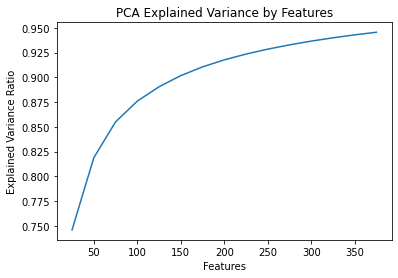

In [9]:
plt.plot(pca_vals,total_pca)
plt.title("PCA Explained Variance by Features")
plt.xlabel("Features")
plt.ylabel("Explained Variance Ratio")

### Fit Optimal PCA Model to images dataset to reduce features to 225

225 was decided on because as seen above the payoff of more features is not worth computational expense

In [5]:
pca = PCA(n_components=225)
pca.fit(images_np)
images_np = pca.transform(images_np)

In [6]:
#Code below transforms images and labels lists into numpy arrays so we can use them in sklearn
#We also pickled these arrays so that we don't have to rerun code above and can just grab arrays from path
print("Size of Images after Stack",sys.getsizeof(images_np))
with open("images_np.pkl","wb") as file:
    pickle.dump(images_np,file)
labels_np = np.array(labels)
labels_np = labels_np.ravel()
with open("labels_np.pkl","wb") as file:
    pickle.dump(labels_np,file)

Size of Images after Stack 72000112


# NOTICE - only run cell below if need to recover arrays, rather than running data ingestion again, which is time consuming 

In [2]:
#SEE NOTE ABOVE
#This cell is only meant to be run to load numpy arrays from local storage rather than running data ingestion component again
import pickle
import sys
print("Beggining Load",time.asctime())
with open("images_np.pkl","rb") as file:
    images_np=pickle.load(file)

with open("labels_np.pkl","rb") as file:
    labels_np=pickle.load(file)
print("Finished Load",time.asctime())
print("Size of Images after Load",sys.getsizeof(images_np))

Beggining Load Mon Mar 11 17:00:22 2024
Finished Load Mon Mar 11 17:00:22 2024
Size of Images after Load 112


In [3]:
#Shows amount of features, used for debug
print(len(images_np[0]))
print(labels_np[0])

225
3622 brick 1x3 


In [4]:
#Encodes labels for svm
label_enc = LabelEncoder()
labels_np_enc = label_enc.fit_transform(labels_np)

In [16]:
print(labels_np_enc[0])
print("Unique Labels:",len(np.unique(labels_np_enc)))

31
Unique Labels: 50


# Run Model

Uses train split of 75% and then runs hyperparameter search of 144 possible fits.

In [6]:
X_train,X_test,y_train,y_test = train_test_split(images_np,labels_np_enc,train_size=0.75,random_state=0)

In [7]:
# Hyperparameter Search using GridsearchCV on preset parameters, displaying best model
print("Beginning GridSearch",time.asctime())
c_vals = [0.1,1,5,10,25,100]
g_vals = [0.01,0.1,0.5,1,10,100]
hyper_params = [{"gamma":g_vals,'C': c_vals}]
lego_svm = GridSearchCV(SVC(kernel='rbf'), hyper_params, cv=4, scoring='accuracy',n_jobs=-1,verbose=30)
lego_svm.fit(X_train, y_train)
lego_svm.cv_results_
print("Finished",time.asctime())
print(lego_svm.best_params_)

Beginning GridSearch Mon Mar 11 17:02:46 2024
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Finished Mon Mar 11 17:32:21 2024
{'C': 25, 'gamma': 0.01}


### Best Model Run and Scoring for Accuracy, Precision, Recall, and F1

In [12]:
#Runs the model that performed best from above and displays scores
from sklearn.metrics import precision_recall_fscore_support
print("Beggining Best Model Run",time.asctime())
best_model = SVC(kernel="rbf",gamma=lego_svm.best_params_["gamma"],C=lego_svm.best_params_["C"])
best_model.fit(X_train,y_train)
print("Finished",time.asctime())
results = best_model.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test,results))
#Support score not used as per initial outline
#Default for fscore is 1, meaning f1 score
print("Overall Score: ",precision_recall_fscore_support(y_test,results,average="macro"))


Beggining Best Model Run Mon Mar 11 17:43:09 2024
Finished Mon Mar 11 17:45:51 2024
Accuracy Score: 0.458
Overall Score:  (0.6976858411952075, 0.46200058862768884, 0.4989117509813634, None)


### Confusion Matrix

Text(0, 0.5, 'Actual')

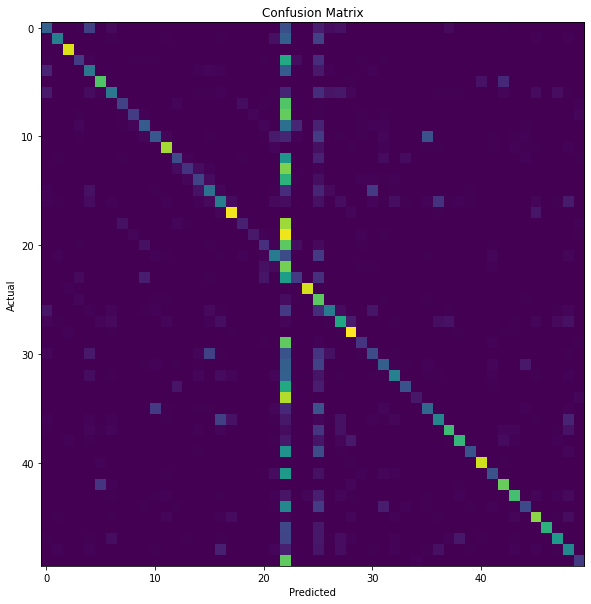

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix(y_test,results))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")